# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from joblib import Parallel, delayed

warnings.filterwarnings('once')

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## 1. Data Cleaning

In [2]:
df = pd.read_csv('student_data.csv')
df2 = pd.read_csv('hold_out_features.csv')
df2.columns
df2.drop(columns = ['Unnamed: 0', 'ID'],axis=1,inplace=True)

In [3]:
df.shape

(23999, 25)

In [4]:
df['default payment next month'].value_counts()

0    18691
1     5308
Name: default payment next month, dtype: int64

In [5]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,2873,350000,1,1,2,37,-2,-2,-2,-2,...,466,466,316,316,316,466,466,316,316,0
1,3598,50000,2,2,1,37,2,2,2,0,...,13026,13268,13497,5500,0,580,600,600,600,0
2,27623,50000,2,1,2,23,-1,-1,-1,-1,...,4800,9810,660,2548,2321,4800,9810,660,2980,0
3,6874,20000,1,3,1,56,0,0,0,0,...,13784,13420,13686,1508,1216,1116,0,490,658,0
4,6444,110000,2,2,2,32,0,0,0,0,...,108829,110557,106082,5400,5400,4100,4100,4100,4200,0


### Null Values

First, let's handle null values.

In [6]:
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [7]:
df2.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dtype: int64

There are no null values in this dataset! Great. Next, let's look at what data types we are working with.

In [8]:
# data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23999 entries, 0 to 23998
Data columns (total 25 columns):
ID                            23999 non-null int64
LIMIT_BAL                     23999 non-null int64
SEX                           23999 non-null int64
EDUCATION                     23999 non-null int64
MARRIAGE                      23999 non-null int64
AGE                           23999 non-null int64
PAY_0                         23999 non-null int64
PAY_2                         23999 non-null int64
PAY_3                         23999 non-null int64
PAY_4                         23999 non-null int64
PAY_5                         23999 non-null int64
PAY_6                         23999 non-null int64
BILL_AMT1                     23999 non-null int64
BILL_AMT2                     23999 non-null int64
BILL_AMT3                     23999 non-null int64
BILL_AMT4                     23999 non-null int64
BILL_AMT5                     23999 non-null int64
BILL_AMT6               

### Categorical Features

Looking at our data, we can see that our categorical features are:
* `SEX`
* `EDUCATION`
* `MARRIAGE`
* `PAY_X` with X = 0,2-6

We also see that the ID column isn't useful to us since we don't need another index, so we'll remove it.

In [9]:
#Dropping ID since we don't need to index them additionally
df.drop(columns = ['ID'],axis=1,inplace=True)

In [10]:
df.shape

(23999, 24)

Let's look at our categorical variables further. First, `SEX`:

In [11]:
#SEX: Gender (1=male, 2=female)
df['SEX'].value_counts()

2    14486
1     9513
Name: SEX, dtype: int64

We now change this variable to have the values that we would expect of a dummy variable.

In [12]:
#Changing these values to be 0 = female, 1 = male
df['SEX']=df['SEX'].apply(lambda x: 0 if x ==2 else x)
df['SEX'].value_counts()

0    14486
1     9513
Name: SEX, dtype: int64

In [13]:
df2['SEX']=df2['SEX'].apply(lambda x: 0 if x ==2 else x)
df2['SEX'].value_counts()

0    3626
1    2375
Name: SEX, dtype: int64

Next, `EDUCATION`.

In [14]:
df['EDUCATION'].describe()

count    23999.000000
mean         1.856786
std          0.791939
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          6.000000
Name: EDUCATION, dtype: float64

In [15]:
#Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)
df['EDUCATION'].value_counts()

2    11188
1     8442
3     3994
5      223
4      100
6       41
0       11
Name: EDUCATION, dtype: int64

Let's change this variable to have a 0 for all unknown values (ex. 4 = others).

In [16]:
#setting 0,4-6 to others
df['EDUCATION']=df['EDUCATION'].apply(lambda x: 0 if x >=4 else x)
df['EDUCATION'].value_counts()

2    11188
1     8442
3     3994
0      375
Name: EDUCATION, dtype: int64

In [17]:
df2['EDUCATION']=df2['EDUCATION'].apply(lambda x: 0 if x >=4 else x)
df2['EDUCATION'].value_counts()

2    2842
1    2143
3     923
0      93
Name: EDUCATION, dtype: int64

Now we can create dummy variables for these values and label the columns to match the category they represent.

In [18]:
edu_dummies = pd.get_dummies(df['EDUCATION'], drop_first=True)
edu_dummies.describe()

,1,2,3
count,23999.000000,23999.000000,23999.000000
mean,0.351765,0.466186,0.166424
std,0.477531,0.498866,0.372468
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


In [19]:
edu_dummies2 = pd.get_dummies(df2['EDUCATION'], drop_first=True)
edu_dummies2.describe()

,1,2,3
count,6001.000000,6001.000000,6001.000000
mean,0.357107,0.473588,0.153808
std,0.479187,0.499344,0.360794
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


Next up is `MARRIAGE`

In [20]:
#MARRIAGE: Marital status (1=married, 2=single, 3=others)
df['MARRIAGE'].value_counts()

2    12735
1    10958
3      263
0       43
Name: MARRIAGE, dtype: int64

Like with education, let's change this variable to have a 0 for all unknown values and create dummy variables for the others.

In [21]:
df['MARRIAGE']=df['MARRIAGE'].apply(lambda x: 0 if x ==3 else x)
df['MARRIAGE'].value_counts()

2    12735
1    10958
0      306
Name: MARRIAGE, dtype: int64

In [22]:
df2['MARRIAGE']=df2['MARRIAGE'].apply(lambda x: 0 if x ==3 else x)
df2['MARRIAGE'].value_counts()

2    3229
1    2701
0      71
Name: MARRIAGE, dtype: int64

In [23]:
marriage_dummies = pd.get_dummies(df['MARRIAGE'], drop_first=True)
marriage_dummies.describe()

,1,2
count,23999.000000,23999.000000
mean,0.456602,0.530647
std,0.498123,0.499070
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [24]:
marriage_dummies2 = pd.get_dummies(df2['MARRIAGE'], drop_first=True)
marriage_dummies2.describe()

,1,2
count,6001.000000,6001.000000
mean,0.450092,0.538077
std,0.497544,0.498590
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [25]:
print(marriage_dummies.describe())

                  1             2
count  23999.000000  23999.000000
mean       0.456602      0.530647
std        0.498123      0.499070
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      1.000000
75%        1.000000      1.000000
max        1.000000      1.000000


Lastly, we have `PAY_X` columns.

_PAY_X: History of past payment._ <br>
_X values (0 = repayment status in September, 1 = repayment status in August, . . .,6 = repayment status in April)_ <br>
_Repayment Status (-1 = pay duly, 1 = payment delay for one month, 2 = payment delay for two months, . . ., 8 = payment delay for eight months, 9 = payment delay for nine months and above)_

We'll change the repayment status to be the following and create dummy variables for these.
* 0 = on time
* 1 = one month late
* 2 = two+ months late

In [26]:
df['PAY_0']= df['PAY_0'].apply(lambda x: 3 if x >0 else x)
df['PAY_0']= df['PAY_0'].apply(lambda x: 2 if x ==0 else x)
df['PAY_0']= df['PAY_0'].apply(lambda x: 1 if x ==-1 else x)
df['PAY_0']= df['PAY_0'].apply(lambda x: 0 if x ==-2 else x)
print(df['PAY_0'].value_counts())
print('\n')

for i in range(2,7):
    df[f'PAY_{i}']= df[f'PAY_{i}'].apply(lambda x: 3 if x >0 else x)
    df[f'PAY_{i}']= df[f'PAY_{i}'].apply(lambda x: 2 if x ==0 else x)
    df[f'PAY_{i}']= df[f'PAY_{i}'].apply(lambda x: 1 if x ==-1 else x)
    df[f'PAY_{i}']= df[f'PAY_{i}'].apply(lambda x: 0 if x ==-2 else x)
    print(df[f'PAY_{i}'].value_counts())
    print('\n')

2    11835
3     5440
1     4544
0     2180
Name: PAY_0, dtype: int64


2    12613
1     4851
3     3529
0     3006
Name: PAY_2, dtype: int64


2    12594
1     4776
3     3383
0     3246
Name: PAY_3, dtype: int64


2    13212
1     4523
0     3453
3     2811
Name: PAY_4, dtype: int64


2    13624
1     4374
0     3617
3     2384
Name: PAY_5, dtype: int64


2    13096
1     4560
0     3878
3     2465
Name: PAY_6, dtype: int64




In [27]:
df2['PAY_0']= df2['PAY_0'].apply(lambda x: 3 if x >0 else x)
df2['PAY_0']= df2['PAY_0'].apply(lambda x: 2 if x ==0 else x)
df2['PAY_0']= df2['PAY_0'].apply(lambda x: 1 if x ==-1 else x)
df2['PAY_0']= df2['PAY_0'].apply(lambda x: 0 if x ==-2 else x)
print(df2['PAY_0'].value_counts())
print('\n')

for i in range(2,7):
    df2[f'PAY_{i}']= df2[f'PAY_{i}'].apply(lambda x: 3 if x >0 else x)
    df2[f'PAY_{i}']= df2[f'PAY_{i}'].apply(lambda x: 2 if x ==0 else x)
    df2[f'PAY_{i}']= df2[f'PAY_{i}'].apply(lambda x: 1 if x ==-1 else x)
    df2[f'PAY_{i}']= df2[f'PAY_{i}'].apply(lambda x: 0 if x ==-2 else x)
    print(df2[f'PAY_{i}'].value_counts())
    print('\n')

2    2902
3    1378
1    1142
0     579
Name: PAY_0, dtype: int64


2    3117
1    1199
3     909
0     776
Name: PAY_2, dtype: int64


2    3170
1    1162
0     839
3     830
Name: PAY_3, dtype: int64


2    3243
1    1164
0     895
3     699
Name: PAY_4, dtype: int64


2    3323
1    1165
0     929
3     584
Name: PAY_5, dtype: int64


2    3190
1    1180
0    1017
3     614
Name: PAY_6, dtype: int64




In [28]:
# Looking at the information for these columns, it seems more complicated than the rest. We'll have to come back to it after some EDA.

### Outliers

Our continuous features are:
* `LIMIT_BAL`
* `AGE`
* `BILL_AMTX`
* `PAY_AMTX` <br>
with X = 1-6

Let's look at these in more detail.

In [29]:
continuous = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
for column in continuous:
    print(df[column].describe())
    print('\n')

count      23999.000000
mean      167825.729405
std       129915.115993
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64


count    23999.000000
mean        35.523230
std          9.253986
min         21.000000
25%         28.000000
50%         34.000000
75%         42.000000
max         79.000000
Name: AGE, dtype: float64


count     23999.000000
mean      51589.034710
std       74104.132627
min     -165580.000000
25%        3577.500000
50%       22472.000000
75%       67767.000000
max      964511.000000
Name: BILL_AMT1, dtype: float64


count     23999.000000
mean      49521.698112
std       71551.215125
min      -67526.000000
25%        2958.000000
50%       21290.000000
75%       64635.500000
max      983931.000000
Name: BILL_AMT2, dtype: float64


count    2.399900e+04
mean     4.747483e+04
std      7.001082e+04
min     -1.572640e+05
25%      2.718000e+03
50%      2.022300e+04
75

With Outliers:


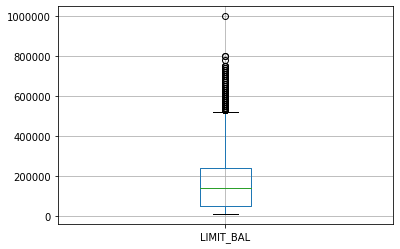

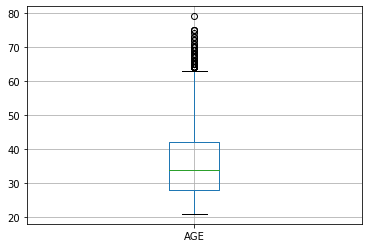

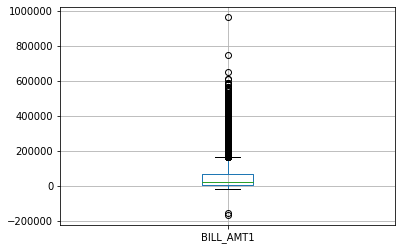

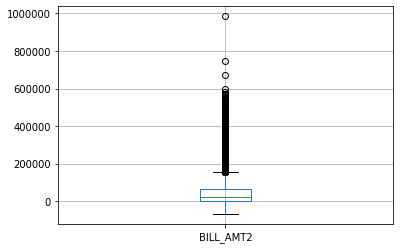

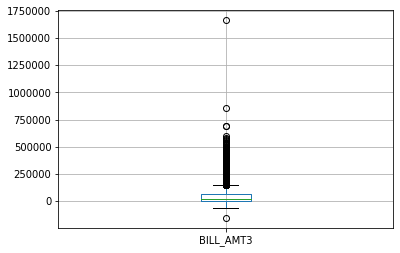

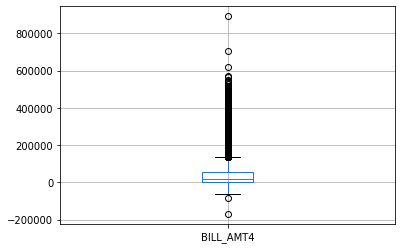

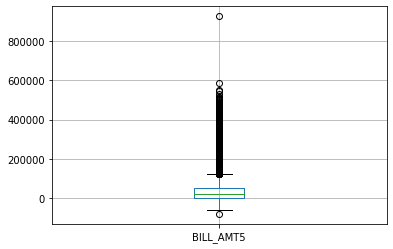

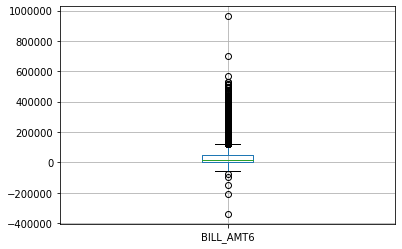

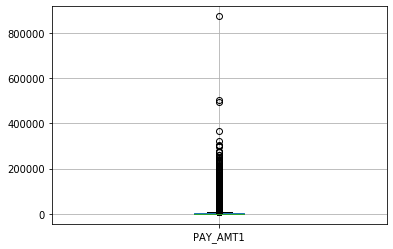

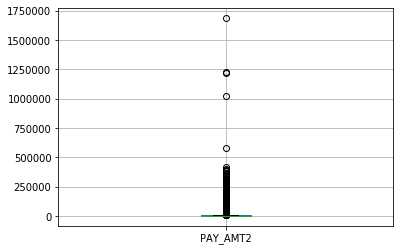

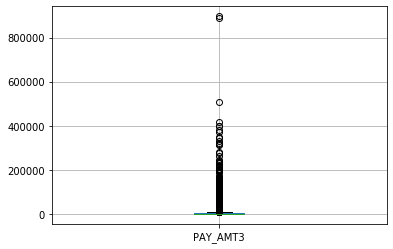

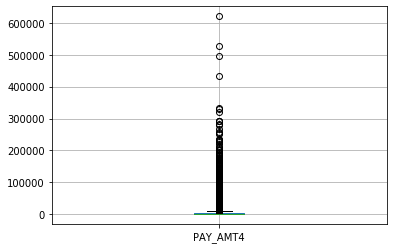

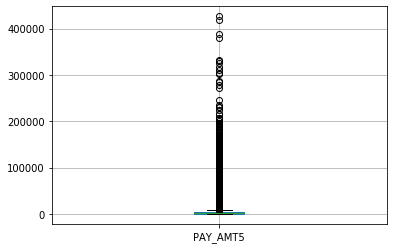

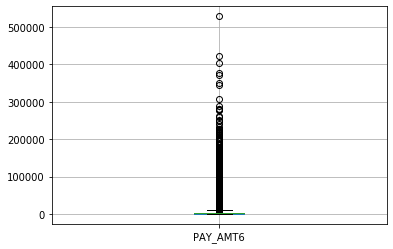

In [30]:
print("With Outliers:")
for column in continuous:
    df.boxplot(column=column)
    plt.show()

We want to leave the `AGE` column alone as we want to include all age groups in our data, and the range of 21-79 seems reasonable. Let's now check how removing the outliers from the other columns would affect our dataset.

In [31]:
def remove_outliers(continous_columns, dataframe):
    """Return a dataframe with any values below the lower fence and above the upper fence removed from given columns in the given dataframe."""
    for column in continous_columns:
        # calculate values for lower fence and upper fence
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_fence = Q1 - 1.5 * IQR
        upper_fence = Q3 + 1.5 * IQR
        # remove rows from dataframe which fall out of this range
        num_removing = dataframe.shape[0]
        new_df = dataframe[dataframe[column] > lower_fence]
        new_df = dataframe[dataframe[column] < upper_fence]
        num_removing -= new_df.shape[0]
        print(f"{num_removing} rows will be removed from {column}.")
    return new_df

In [32]:
continuous.remove('AGE')
remove_outliers(continuous, df)

139 rows will be removed from LIMIT_BAL.
1925 rows will be removed from BILL_AMT1.
1914 rows will be removed from BILL_AMT2.
1973 rows will be removed from BILL_AMT3.
2100 rows will be removed from BILL_AMT4.
2204 rows will be removed from BILL_AMT5.
2172 rows will be removed from BILL_AMT6.
2218 rows will be removed from PAY_AMT1.
2208 rows will be removed from PAY_AMT2.
2081 rows will be removed from PAY_AMT3.
2402 rows will be removed from PAY_AMT4.
2339 rows will be removed from PAY_AMT5.
2371 rows will be removed from PAY_AMT6.


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,350000,1,1,2,37,0,0,0,0,0,...,466,466,316,316,316,466,466,316,316,0
1,50000,0,2,1,37,3,3,3,2,2,...,13026,13268,13497,5500,0,580,600,600,600,0
2,50000,0,1,2,23,1,1,1,1,1,...,4800,9810,660,2548,2321,4800,9810,660,2980,0
3,20000,1,3,1,56,2,2,2,2,3,...,13784,13420,13686,1508,1216,1116,0,490,658,0
4,110000,0,2,2,32,2,2,2,2,2,...,108829,110557,106082,5400,5400,4100,4100,4100,4200,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23993,230000,0,1,1,35,2,2,1,1,1,...,0,89,2398,78,1897,0,89,2398,671,1
23994,50000,0,1,2,24,2,2,2,0,0,...,0,0,0,7522,0,0,0,0,0,1
23995,250000,1,3,1,44,1,1,1,1,1,...,43546,38051,576,3924,4482,43676,38166,576,2389,1
23996,50000,1,3,2,26,3,2,2,3,3,...,44891,47654,48721,1800,4000,0,3500,2000,0,1


We can see from this output that removing the outliers from `BILL_AMTX` and `PAY_AMTX` would cause us to lose over 12,000 data points. As such, we'll need a different way to work with these columns. We'll come back to these during our feature engineering phase.

In [33]:
df.shape

(23999, 24)

In [34]:
df = remove_outliers(['LIMIT_BAL'], df)

139 rows will be removed from LIMIT_BAL.


Without Outliers:


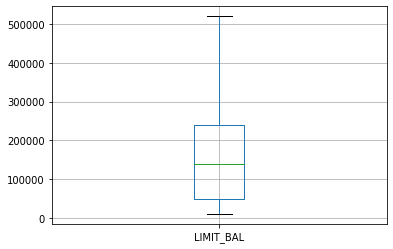

In [35]:
print("Without Outliers:")
df.boxplot(column='LIMIT_BAL')

In [36]:
df.shape

(23860, 24)

## 2. EDA

Our target variable is "default payment next month". Let's rename this column to "default", to make it easier to work with in our code.

In [37]:
df.rename(columns={"default payment next month": "default"},inplace = True)

Target Variable
default
0    18568
1     5292
Name: default, dtype: int64


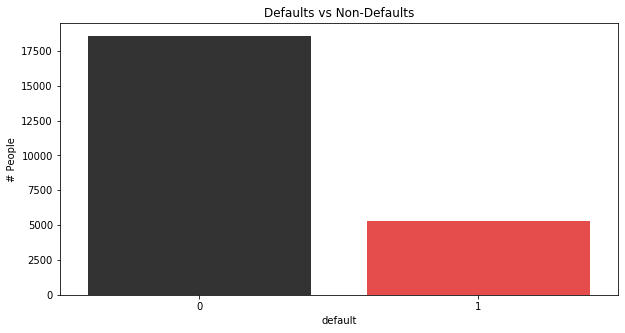

In [38]:
# Default Count
print('Target Variable')
print(df.groupby(['default']).default.count())

# Target Variable Countplot
plt.figure(figsize = (10,5))
sns.countplot(df['default'], alpha =.80, palette= ['black','red'])
plt.title('Defaults vs Non-Defaults')
plt.ylabel('# People')
plt.show()

Our majority class is 0, so most people do not default on their payment. We can also see there's a 78/22 split, so we don't have to worry about a class imbalance. 

Next, let's look at the distribution of our column values.

In [39]:
# Identify numeric features
print('Continuous Variables')
print(df[['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1'
         ,'PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].describe().transpose())
print('\n')
print('Discrete Variables')
print(df.groupby('SEX').SEX.count())
print(df.groupby('EDUCATION').EDUCATION.count())
print(df.groupby('MARRIAGE').MARRIAGE.count())
print(df.groupby('PAY_0').PAY_0.count())
for i in range(2,7):
    print(df.groupby(f'PAY_{i}')[f'PAY_{i}'].count())

Continuous Variables
             count           mean            std       min       25%  \
LIMIT_BAL  23860.0  165194.873428  125498.926446   10000.0  50000.00   
AGE        23860.0      35.502515       9.258418      21.0     28.00   
BILL_AMT1  23860.0   50879.572883   72193.023082 -165580.0   3549.25   
BILL_AMT2  23860.0   48861.055574   69770.342063  -67526.0   2941.50   
BILL_AMT3  23860.0   46830.711567   68394.282202 -157264.0   2690.25   
BILL_AMT4  23860.0   43169.652305   63102.998239 -170000.0   2360.75   
BILL_AMT5  23860.0   40164.031685   59506.001016  -81334.0   1782.00   
BILL_AMT6  23860.0   38629.067058   58350.617902 -339603.0   1261.75   
PAY_AMT1   23860.0    5627.188474   16485.432826       0.0   1000.00   
PAY_AMT2   23860.0    5959.357837   24420.405910       0.0    838.25   
PAY_AMT3   23860.0    5146.077368   16653.612328       0.0    390.00   
PAY_AMT4   23860.0    4753.119950   15261.724845       0.0    291.00   
PAY_AMT5   23860.0    4698.092205   14867.9

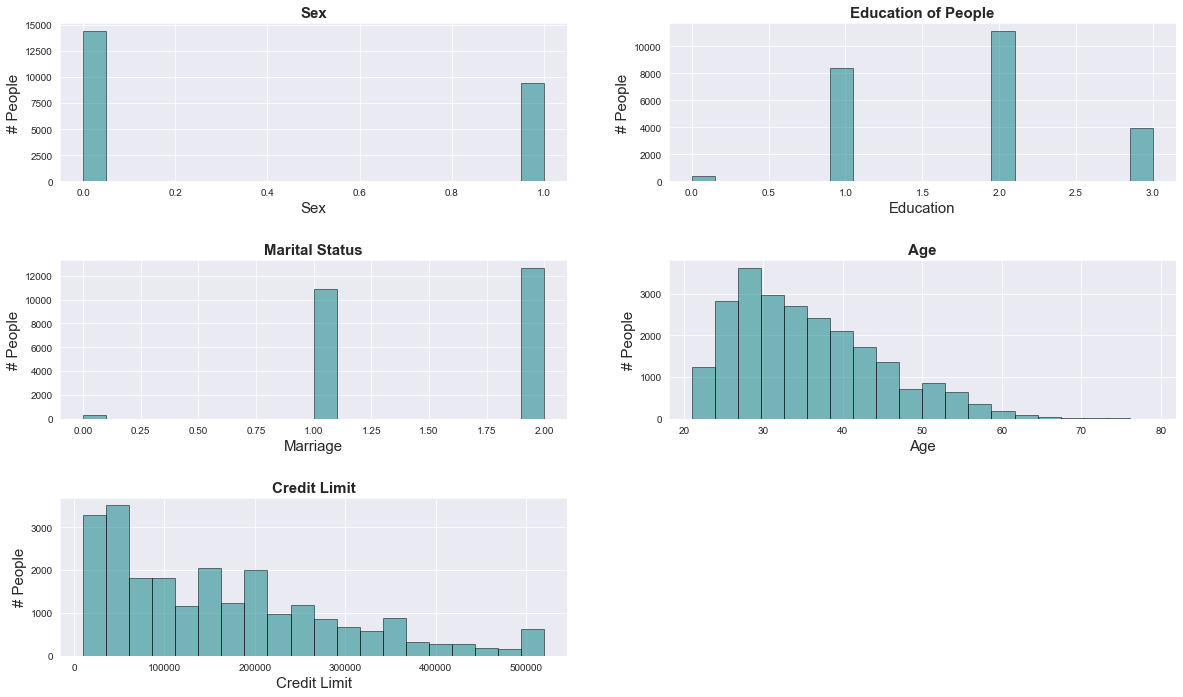

In [40]:
# Subplots of Numeric Features
sns.set_style('darkgrid')
fig = plt.figure(figsize = (20,16))
fig.subplots_adjust(hspace = .50)

ax1 = fig.add_subplot(421)
ax1.hist(df['SEX'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax1.set_xlabel('Sex', fontsize = 15)
ax1.set_ylabel('# People',fontsize = 15)
ax1.set_title('Sex',fontsize = 15,fontweight='bold')

ax2 = fig.add_subplot(422)
ax2.hist(df['EDUCATION'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax2.set_xlabel('Education',fontsize = 15)
ax2.set_ylabel('# People',fontsize = 15)
ax2.set_title('Education of People',fontsize = 15,fontweight='bold')

ax3 = fig.add_subplot(423)
ax3.hist(df['MARRIAGE'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax3.set_xlabel('Marriage',fontsize = 15)
ax3.set_ylabel('# People',fontsize = 15)
ax3.set_title('Marital Status',fontsize = 15,fontweight='bold')

ax4 = fig.add_subplot(424)
ax4.hist(df['AGE'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax4.set_xlabel('Age', fontsize = 15)
ax4.set_ylabel('# People',fontsize = 15)
ax4.set_title('Age',fontsize = 15,fontweight='bold')

ax1 = fig.add_subplot(425)
ax1.hist(df['LIMIT_BAL'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax1.set_xlabel('Credit Limit', fontsize = 15)
ax1.set_ylabel('# People',fontsize = 15)
ax1.set_title('Credit Limit',fontsize = 15,fontweight='bold')

plt.show()

From these graphs we see a most of our customers are under the age of 50, with the mean age at 25. We also see most credit limits are on the lower end. Additionally, most customers have some form of higher education.

Next, let's compare some of our numeric features with our target variable.

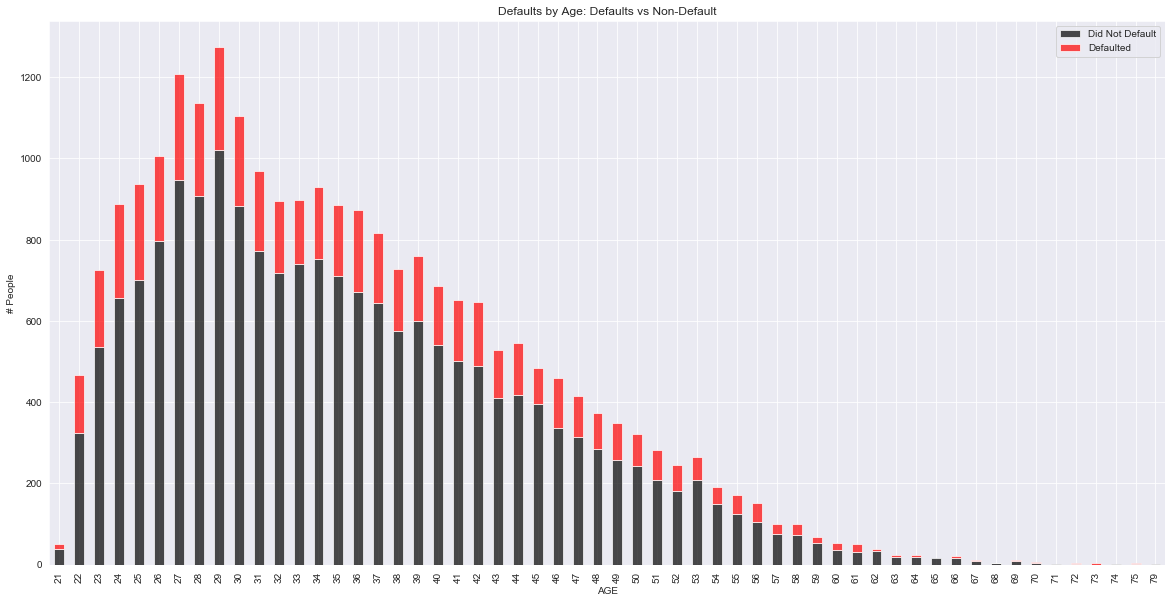

In [41]:
pclass = df.groupby(['AGE','default']).AGE.count().unstack()
p = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'Defaults by Age: Defaults vs Non-Default', 
                   color = ['black','red'], alpha = .70,
                figsize = (20,10))
p.set_xlabel('AGE')
p.set_ylabel('# People')
p.legend(['Did Not Default','Defaulted'])
plt.show()

Since we have a wide range of ages, it's a bit difficult to grab any insight from this graph. Although the default rate seems to drop as age goes up, this could just be because we have less data for older people.

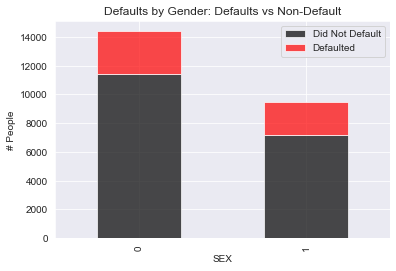

In [42]:
pclass = df.groupby(['SEX','default']).AGE.count().unstack()
p = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'Defaults by Gender: Defaults vs Non-Default', 
                   color = ['black','red'], alpha = .70)
p.set_xlabel('SEX')
p.set_ylabel('# People')
p.legend(['Did Not Default','Defaulted'])
plt.show()

We can see a slight majority of customers are male, but around 20% of both classes defaulted.

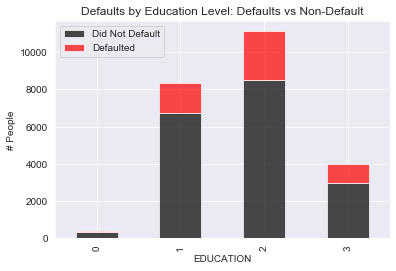

In [43]:
pclass = df.groupby(['EDUCATION','default']).AGE.count().unstack()
p = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'Defaults by Education Level: Defaults vs Non-Default', 
                   color = ['black','red'], alpha = .70)
p.set_xlabel('EDUCATION')
p.set_ylabel('# People')
p.legend(['Did Not Default','Defaulted'])
plt.show()

Most customers have a higher education. Those in the university class have the highest rate of defaulting.

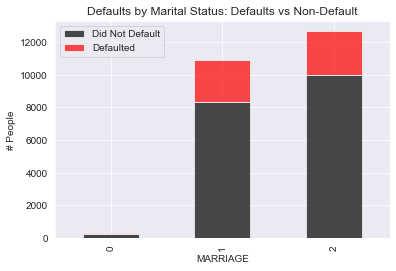

In [44]:
pclass = df.groupby(['MARRIAGE','default']).AGE.count().unstack()
p = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'Defaults by Marital Status: Defaults vs Non-Default', 
                   color = ['black','red'], alpha = .70)
p.set_xlabel('MARRIAGE')
p.set_ylabel('# People')
p.legend(['Did Not Default','Defaulted'])
plt.show()

Most customers are single, but both classes have around a 20% rate of defaulting.

## 3. Feature Engineering

First, we will go back and use the dummy variables we made in our cleaning section to create new categorical columns.

In [45]:
df = df.drop(['EDUCATION'], axis=1)
df = pd.concat([df, edu_dummies], axis=1)
df.rename(columns={1: 'grad_school', 2: 'university', 3: 'highschool'},inplace=True)

In [46]:
df = df.drop(['MARRIAGE'], axis=1)
df = pd.concat([df, marriage_dummies], axis=1)
df.rename(columns={1: 'married', 2: 'single'},inplace=True)

In [47]:
df2 = df2.drop(['EDUCATION'], axis=1)
df2 = pd.concat([df2, edu_dummies2], axis=1)
df2.rename(columns={1: 'grad_school', 2: 'university', 3: 'highschool'},inplace=True)

In [48]:
df2 = df2.drop(['MARRIAGE'], axis=1)
df2 = pd.concat([df2, marriage_dummies2], axis=1)
df2.rename(columns={1: 'married', 2: 'single'},inplace=True)

In [49]:
df2.head()

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,grad_school,university,highschool,married,single
0,240000,1,44,1,1,1,1,1,1,4221,...,2701,2427,1104,2362,519,1,0,0,1,0
1,50000,1,41,2,2,2,2,2,2,49782,...,1753,1433,990,967,1071,0,0,1,1,0
2,20000,0,41,2,2,2,2,2,2,8777,...,1600,2000,2000,2000,2000,0,0,1,1,0
3,320000,0,34,0,0,0,0,0,0,-532,...,4,0,0,0,0,1,0,0,0,1
4,120000,0,23,2,2,2,2,2,2,64049,...,2500,3100,2700,2800,2800,0,1,0,1,0


In [50]:
df.head()

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,grad_school,university,highschool,married,single
0,350000.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,316.0,...,466.0,466.0,316.0,316.0,0.0,1,0,0,0,1
1,50000.0,0.0,37.0,3.0,3.0,3.0,2.0,2.0,2.0,40994.0,...,580.0,600.0,600.0,600.0,0.0,0,1,0,1,0
2,50000.0,0.0,23.0,1.0,1.0,1.0,1.0,1.0,1.0,3430.0,...,4800.0,9810.0,660.0,2980.0,0.0,1,0,0,0,1
3,20000.0,1.0,56.0,2.0,2.0,2.0,2.0,3.0,2.0,10847.0,...,1116.0,0.0,490.0,658.0,0.0,0,0,1,1,0
4,110000.0,0.0,32.0,2.0,2.0,2.0,2.0,2.0,2.0,108159.0,...,4100.0,4100.0,4100.0,4200.0,0.0,0,1,0,0,1


Next, we will need to deal with the `PAY_X`, `BILL_AMTX` and `PAY_AMTX` columns, which contain payment and bill data for 6 months. We'll combine these into other usable features.

First, we'll take the `PAY_X` columns and combine them into a new column which contains data of past payment

In [51]:
df['Past_Payment'] = df['PAY_0']+df['PAY_2']+df['PAY_3']+df['PAY_4']+df['PAY_5']+df['PAY_6']
df['Past_Payment'].describe()

count    23860.000000
mean        10.073428
std          4.480120
min          0.000000
25%          7.000000
50%         12.000000
75%         12.000000
max         18.000000
Name: Past_Payment, dtype: float64

In [52]:
df2['Past_Payment'] = df2['PAY_0']+df2['PAY_2']+df2['PAY_3']+df2['PAY_4']+df2['PAY_5']+df2['PAY_6']
df2['Past_Payment'].describe()

count    6001.000000
mean        9.989002
std         4.515183
min         0.000000
25%         7.000000
50%        12.000000
75%        12.000000
max        18.000000
Name: Past_Payment, dtype: float64

In [53]:
#Negative bill amounts
print(df['BILL_AMT1'][df['BILL_AMT1']<=0].count())
print(df['BILL_AMT2'][df['BILL_AMT2']<=0].count())
print(df['BILL_AMT3'][df['BILL_AMT3']<=0].count())
print(df['BILL_AMT4'][df['BILL_AMT4']<=0].count())
print(df['BILL_AMT5'][df['BILL_AMT5']<=0].count())
print(df['BILL_AMT6'][df['BILL_AMT6']<=0].count())
df['BILL_AMT1']= df['BILL_AMT1'].apply(lambda x: 0 if x <=0 else x)
df['BILL_AMT2']= df['BILL_AMT2'].apply(lambda x: 0 if x <=0 else x)
df['BILL_AMT3']= df['BILL_AMT3'].apply(lambda x: 0 if x <=0 else x)
df['BILL_AMT4']= df['BILL_AMT4'].apply(lambda x: 0 if x <=0 else x)
df['BILL_AMT5']= df['BILL_AMT5'].apply(lambda x: 0 if x <=0 else x)
df['BILL_AMT6']= df['BILL_AMT6'].apply(lambda x: 0 if x <=0 else x)


#First we tried to take the %paid each month and average this. However due to some people paying 0 
#paying months together this metric created some errors. Now summing the total bill and total
#payment amount
df['Bill_Total']=(df['BILL_AMT1']+df['BILL_AMT2']+df['BILL_AMT3']+df['BILL_AMT4']+df['BILL_AMT5']+df['BILL_AMT6'])
df['Pay_Total']=(df['PAY_AMT1']+df['PAY_AMT2']+df['PAY_AMT3']+df['PAY_AMT4']+df['PAY_AMT5']+df['PAY_AMT6'])
df['Pay_Percent']=df['Pay_Total']/df['Bill_Total']

print(df['Bill_Total'][df['Bill_Total']==0].count())

#going to drop anyhting where bill total over 6 months is 0
df.drop(df[df['Bill_Total'] == 0 ].index,inplace = True)
df.shape

2055
2531
2792
3057
3302
3727
779


(23220, 31)

In [54]:
#Negative bill amounts
print(df2['BILL_AMT1'][df2['BILL_AMT1']<=0].count())
print(df2['BILL_AMT2'][df2['BILL_AMT2']<=0].count())
print(df2['BILL_AMT3'][df2['BILL_AMT3']<=0].count())
print(df2['BILL_AMT4'][df2['BILL_AMT4']<=0].count())
print(df2['BILL_AMT5'][df2['BILL_AMT5']<=0].count())
print(df2['BILL_AMT6'][df2['BILL_AMT6']<=0].count())
df2['BILL_AMT1']= df2['BILL_AMT1'].apply(lambda x: 0 if x <=0 else x)
df2['BILL_AMT2']= df2['BILL_AMT2'].apply(lambda x: 0 if x <=0 else x)
df2['BILL_AMT3']= df2['BILL_AMT3'].apply(lambda x: 0 if x <=0 else x)
df2['BILL_AMT4']= df2['BILL_AMT4'].apply(lambda x: 0 if x <=0 else x)
df2['BILL_AMT5']= df2['BILL_AMT5'].apply(lambda x: 0 if x <=0 else x)
df2['BILL_AMT6']= df2['BILL_AMT6'].apply(lambda x: 0 if x <=0 else x)


#First we tried to take the %paid each month and average this. However due to some people paying 0 
#paying months together this metric created some errors. Now summing the total bill and total
#payment amount
df2['Bill_Total']=(df2['BILL_AMT1']+df2['BILL_AMT2']+df2['BILL_AMT3']+df2['BILL_AMT4']+df2['BILL_AMT5']+df2
                   ['BILL_AMT6'])
df2['Pay_Total']=(df2['PAY_AMT1']+df2['PAY_AMT2']+df2['PAY_AMT3']+df2['PAY_AMT4']+df2['PAY_AMT5']+df2['PAY_AMT6'])
df2['Pay_Percent']=df2['Pay_Total']/df2['Bill_Total']

print(df2['Bill_Total'][df2['Bill_Total']==0].count())

538
635
728
805
853
974
186


In [55]:
#binning Pay Percent: 100% = 0, 95%-99% = 1, 85%-94% = 2, <85% = 3

df['Pay_Percent_Bin'] = df['Pay_Percent'].apply(lambda x: .01 if x == 0 else x )
df['Pay_Percent_Bin'] = df['Pay_Percent_Bin'].apply(lambda x: 0 if x>=1 else x )
df['Pay_Percent_Bin'] = df['Pay_Percent_Bin'].apply(lambda x: 3 if (x<.85)&(x>0) else x )
df['Pay_Percent_Bin'] = df['Pay_Percent_Bin'].apply(lambda x: 2 if (x>=.85)&(x<.95) else x )
df['Pay_Percent_Bin'] = df['Pay_Percent_Bin'].apply(lambda x: 1 if (x>=.95)&(x<1) else x )
df.drop(columns = 'Pay_Percent',axis=1,inplace=True)

In [56]:
df2['Pay_Percent_Bin'] = df2['Pay_Percent'].apply(lambda x: .01 if x == 0 else x )
df2['Pay_Percent_Bin'] = df2['Pay_Percent_Bin'].apply(lambda x: 0 if x>=1 else x )
df2['Pay_Percent_Bin'] = df2['Pay_Percent_Bin'].apply(lambda x: 3 if (x<.85)&(x>0) else x )
df2['Pay_Percent_Bin'] = df2['Pay_Percent_Bin'].apply(lambda x: 2 if (x>=.85)&(x<.95) else x )
df2['Pay_Percent_Bin'] = df2['Pay_Percent_Bin'].apply(lambda x: 1 if (x>=.95)&(x<1) else x )
df2.drop(columns = 'Pay_Percent',axis=1,inplace=True)

Pay Percent Bin Summary


default            0.0   1.0
Pay_Percent_Bin             
0.0               2384   454
1.0                451    48
2.0                712   133
3.0              14517  4382


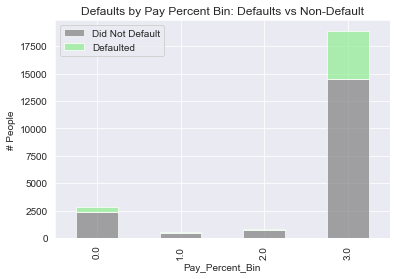

In [57]:
# Pay Percent Bin summary
print('Pay Percent Bin Summary')

print('\n')
print(df.groupby(['Pay_Percent_Bin','default']).Pay_Percent_Bin.count().unstack())


pclass = df.groupby(['Pay_Percent_Bin','default']).Pay_Percent_Bin.count().unstack()
p1 = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'Defaults by Pay Percent Bin: Defaults vs Non-Default', 
                   color = ['grey','lightgreen'], alpha = .70)
p1.set_xlabel('Pay_Percent_Bin')
p1.set_ylabel('# People')
p1.legend(['Did Not Default','Defaulted'])
plt.show()

In [58]:
#binning Pay Percent: 100% = 0, 95%-99% = 1, 85%-94% = 2, <85% = 3
paypercent_dummies = pd.get_dummies(df['Pay_Percent_Bin'], drop_first=True)
paypercent_dummies.describe()
df = df.drop(['Pay_Percent_Bin'], axis=1)
df = pd.concat([df, paypercent_dummies], axis=1)
df.rename(columns={1: '95%-99%', 2: '85%-94%',3:'<85%'},inplace=True)
df.head()

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,university,highschool,married,single,Past_Payment,Bill_Total,Pay_Total,95%-99%,85%-94%,<85%
0,350000.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,316.0,...,0,0,0,1,0.0,2196.0,2196.0,0,0,0
1,50000.0,0.0,37.0,3.0,3.0,3.0,2.0,2.0,2.0,40994.0,...,1,0,1,0,15.0,162601.0,7880.0,0,0,1
2,50000.0,0.0,23.0,1.0,1.0,1.0,1.0,1.0,1.0,3430.0,...,0,0,0,1,6.0,23477.0,23119.0,1,0,0
3,20000.0,1.0,56.0,2.0,2.0,2.0,2.0,3.0,2.0,10847.0,...,0,1,1,0,13.0,76797.0,4988.0,0,0,1
4,110000.0,0.0,32.0,2.0,2.0,2.0,2.0,2.0,2.0,108159.0,...,1,0,0,1,12.0,648903.0,27300.0,0,0,1


In [59]:
#binning Pay Percent: 100% = 0, 95%-99% = 1, 85%-94% = 2, <85% = 3
paypercent_dummies2 = pd.get_dummies(df2['Pay_Percent_Bin'], drop_first=True)
paypercent_dummies2.describe()
df2 = df2.drop(['Pay_Percent_Bin'], axis=1)
df2 = pd.concat([df2, paypercent_dummies2], axis=1)
df2.rename(columns={1: '95%-99%', 2: '85%-94%',3:'<85%'},inplace=True)
df2.head()

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,university,highschool,married,single,Past_Payment,Bill_Total,Pay_Total,95%-99%,85%-94%,<85%
0,240000,1,44,1,1,1,1,1,1,4221,...,0,0,1,0,6,15003,11301,0,0,1
1,50000,1,41,2,2,2,2,2,2,49782,...,0,1,1,0,12,243743,8030,0,0,1
2,20000,0,41,2,2,2,2,2,2,8777,...,0,1,1,0,12,74595,11600,0,0,1
3,320000,0,34,0,0,0,0,0,0,0,...,0,0,0,1,0,0,4,0,0,0
4,120000,0,23,2,2,2,2,2,2,64049,...,1,0,1,0,12,406751,16900,0,0,1


In [60]:
pastpayment_dummies = pd.get_dummies(df['Past_Payment'], drop_first=True)
pastpayment_dummies.describe()
df = df.drop(['Past_Payment'], axis=1)
df = pd.concat([df, pastpayment_dummies], axis=1)

df.head()

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
0,350000.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,316.0,...,0,0,0,0,0,0,0,0,0,0
1,50000.0,0.0,37.0,3.0,3.0,3.0,2.0,2.0,2.0,40994.0,...,0,0,0,0,0,0,1,0,0,0
2,50000.0,0.0,23.0,1.0,1.0,1.0,1.0,1.0,1.0,3430.0,...,0,0,0,0,0,0,0,0,0,0
3,20000.0,1.0,56.0,2.0,2.0,2.0,2.0,3.0,2.0,10847.0,...,0,0,0,0,1,0,0,0,0,0
4,110000.0,0.0,32.0,2.0,2.0,2.0,2.0,2.0,2.0,108159.0,...,0,0,0,1,0,0,0,0,0,0


In [61]:
pastpayment_dummies2 = pd.get_dummies(df2['Past_Payment'], drop_first=True)
pastpayment_dummies2.describe()
df2 = df2.drop(['Past_Payment'], axis=1)
df2 = pd.concat([df2, pastpayment_dummies2], axis=1)

df2.head()

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,9,10,11,12,13,14,15,16,17,18
0,240000,1,44,1,1,1,1,1,1,4221,...,0,0,0,0,0,0,0,0,0,0
1,50000,1,41,2,2,2,2,2,2,49782,...,0,0,0,1,0,0,0,0,0,0
2,20000,0,41,2,2,2,2,2,2,8777,...,0,0,0,1,0,0,0,0,0,0
3,320000,0,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,120000,0,23,2,2,2,2,2,2,64049,...,0,0,0,1,0,0,0,0,0,0


In [62]:
pay_dummies = {}
pay_dummies[0] = pd.get_dummies(df['PAY_0'], drop_first=True)

for i in range(2,7):
    pay_dummies[i] = pd.get_dummies(df[f'PAY_{i}'], drop_first=True)
    
for key, value in pay_dummies.items():
    print(f"PAY_{key}")
    print(value.describe())
    print("\n")

PAY_0
                1.0           2.0           3.0
count  23220.000000  23220.000000  23220.000000
mean       0.195004      0.506202      0.212360
std        0.396213      0.499972      0.408987
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%        0.000000      1.000000      0.000000
75%        0.000000      1.000000      0.000000
max        1.000000      1.000000      1.000000


PAY_2
                1.0           2.0           3.0
count  23220.000000  23220.000000  23220.000000
mean       0.208269      0.539492      0.151637
std        0.406079      0.498449      0.358676
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%        0.000000      1.000000      0.000000
75%        0.000000      1.000000      0.000000
max        1.000000      1.000000      1.000000


PAY_3
                1.0           2.0           3.0
count  23220.000000  23220.000000  23220.000000
mean       0.20465

In [63]:
pay_dummies2 = {}
pay_dummies2[0] = pd.get_dummies(df2['PAY_0'], drop_first=True)

for i in range(2,7):
    pay_dummies2[i] = pd.get_dummies(df2[f'PAY_{i}'], drop_first=True)
    
for key, value in pay_dummies2.items():
    print(f"PAY_{key}")
    print(value.describe())
    print("\n")

PAY_0
                 1            2            3
count  6001.000000  6001.000000  6001.000000
mean      0.190302     0.483586     0.229628
std       0.392572     0.499772     0.420629
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000
50%       0.000000     0.000000     0.000000
75%       0.000000     1.000000     0.000000
max       1.000000     1.000000     1.000000


PAY_2
                 1            2            3
count  6001.000000  6001.000000  6001.000000
mean      0.199800     0.519413     0.151475
std       0.399883     0.499665     0.358541
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000
50%       0.000000     1.000000     0.000000
75%       0.000000     1.000000     0.000000
max       1.000000     1.000000     1.000000


PAY_3
                 1            2            3
count  6001.000000  6001.000000  6001.000000
mean      0.193634     0.528245     0.138310
std       0.395179     0.499243  

In [64]:
for key,value in pay_dummies.items():
    df = df.drop([f'PAY_{key}'], axis=1)
    df = pd.concat([df, value], axis=1)
    df.rename(columns={1: f'One_month_late_{key}', 2: f'Two_months_late{key}',3: f'Three_or_more{key}'},inplace=True)

In [65]:
for key,value in pay_dummies2.items():
    df2 = df2.drop([f'PAY_{key}'], axis=1)
    df2 = pd.concat([df2, value], axis=1)
    df2.rename(columns={1: f'One_month_late_{key}', 2: f'Two_months_late{key}',3: f'Three_or_more{key}'},inplace=True)

Lastly, we want to create bins for our ages.

In [66]:
#binning ages: 21-25 = 0, 26-39 = 1, 40-59 = 2, 60+ = 3

df['Age_Bin'] = df['AGE'].apply(lambda x: 3 if x>=60 else x )
df['Age_Bin'] = df['Age_Bin'].apply(lambda x: 2 if x>=40 else x )
df['Age_Bin'] = df['Age_Bin'].apply(lambda x: 1 if x>=26 else x )
df['Age_Bin'] = df['Age_Bin'].apply(lambda x: 0 if x>=21 else x )
df['Age_Bin'].value_counts()

1.0    13005
2.0     6804
0.0     3018
3.0      254
Name: Age_Bin, dtype: int64

In [67]:

df2['Age_Bin'] = df2['AGE'].apply(lambda x: 3 if x>=60 else x )
df2['Age_Bin'] = df2['Age_Bin'].apply(lambda x: 2 if x>=40 else x )
df2['Age_Bin'] = df2['Age_Bin'].apply(lambda x: 1 if x>=26 else x )
df2['Age_Bin'] = df2['Age_Bin'].apply(lambda x: 0 if x>=21 else x )
df2['Age_Bin'].value_counts()

1    3417
2    1720
0     800
3      64
Name: Age_Bin, dtype: int64

In [68]:
agebin_dummies = pd.get_dummies(df['Age_Bin'], drop_first=True)
agebin_dummies.describe()
df = df.drop(['Age_Bin'], axis=1)
df = pd.concat([df, agebin_dummies], axis=1)
df.rename(columns={1: '26-39', 2: '40-59',3: '60+'},inplace=True)
df.head()

,LIMIT_BAL,SEX,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,...,Three_or_more4,One_month_late_5,Two_months_late5,Three_or_more5,One_month_late_6,Two_months_late6,Three_or_more6,26-39,40-59,60+
0,350000.0,1.0,37.0,316.0,316.0,316.0,466.0,466.0,316.0,316.0,...,0,0,0,0,0,0,0,1,0,0
1,50000.0,0.0,37.0,40994.0,43594.0,38222.0,13026.0,13268.0,13497.0,5500.0,...,0,0,1,0,0,1,0,1,0,0
2,50000.0,0.0,23.0,3430.0,2478.0,2299.0,4800.0,9810.0,660.0,2548.0,...,0,1,0,0,1,0,0,0,0,0
3,20000.0,1.0,56.0,10847.0,12176.0,12884.0,13784.0,13420.0,13686.0,1508.0,...,0,0,0,1,0,1,0,0,1,0
4,110000.0,0.0,32.0,108159.0,106812.0,108464.0,108829.0,110557.0,106082.0,5400.0,...,0,0,1,0,0,1,0,1,0,0


In [69]:
agebin_dummies2 = pd.get_dummies(df2['Age_Bin'], drop_first=True)
agebin_dummies2.describe()
df2 = df2.drop(['Age_Bin'], axis=1)
df2 = pd.concat([df2, agebin_dummies2], axis=1)
df2.rename(columns={1: '26-39', 2: '40-59',3: '60+'},inplace=True)
df2.head()

,LIMIT_BAL,SEX,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,...,Three_or_more4,One_month_late_5,Two_months_late5,Three_or_more5,One_month_late_6,Two_months_late6,Three_or_more6,26-39,40-59,60+
0,240000,1,44,4221,2188,2701,2427,1104,2362,2188,...,0,1,0,0,1,0,0,0,1,0
1,50000,1,41,49782,50741,48468,39203,28913,26636,1816,...,0,0,1,0,0,1,0,0,1,0
2,20000,0,41,8777,10461,11583,13079,14546,16149,2000,...,0,0,1,0,0,1,0,0,1,0
3,320000,0,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,120000,0,23,64049,65984,66825,68820,69776,71297,3000,...,0,0,1,0,0,1,0,0,0,0


In [70]:
df['Balance_Percent'] = df['BILL_AMT1']/df['LIMIT_BAL']
df['Balance_Percent'].describe()

count    23081.000000
mean         0.440325
std          0.411416
min          0.000000
25%          0.030120
50%          0.353080
75%          0.846470
max          6.455300
Name: Balance_Percent, dtype: float64

In [71]:
df2['Balance_Percent'] = df2['BILL_AMT1']/df2['LIMIT_BAL']
df2['Balance_Percent'].describe()

count    6001.000000
mean        0.419200
std         0.409121
min         0.000000
25%         0.021478
50%         0.299033
75%         0.817900
max         4.140600
Name: Balance_Percent, dtype: float64

## 4. Feature Selection

In [72]:
df.dropna(inplace=True)
y = df['default']
X = df.drop(columns = ['default'],axis=1)
drop_age = ['AGE','26-39','40-59', '60+']
drop_sex = ['SEX']
drop_edu = ['grad_school', 'university', 'highschool']
drop_mar = ['married', 'single']

#X = X.drop(columns = drop_pay,axis=1)
X.columns

Index([       'LIMIT_BAL',              'SEX',              'AGE',
              'BILL_AMT1',        'BILL_AMT2',        'BILL_AMT3',
              'BILL_AMT4',        'BILL_AMT5',        'BILL_AMT6',
               'PAY_AMT1',         'PAY_AMT2',         'PAY_AMT3',
               'PAY_AMT4',         'PAY_AMT5',         'PAY_AMT6',
            'grad_school',       'university',       'highschool',
                'married',           'single',       'Bill_Total',
              'Pay_Total',          '95%-99%',          '85%-94%',
                   '<85%', 'One_month_late_0', 'Two_months_late0',
         'Three_or_more0',                4.0,                5.0,
                      6.0,                7.0,                8.0,
                      9.0,               10.0,               11.0,
                     12.0,               13.0,               14.0,
                     15.0,               16.0,               17.0,
                     18.0, 'One_month_late_0', 'Two_months_lat

In [73]:
X.shape

(23081, 65)

Scaling

In [74]:
scaler = MinMaxScaler()
scaler.fit(X)
X_transformed = scaler.transform(X)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y,test_size = .2, random_state=1)
logreg = LogisticRegression(random_state = 13)
logreg.fit(X_train, y_train)

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=13, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
y_pred_class = logreg.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.8325752653238033


In [77]:
max(y_test.mean(), 1 - y_test.mean())
print(metrics.confusion_matrix(y_test, y_pred_class))

[[3454  212]
 [ 561  390]]


Going to drop Bill and Payment amounts as the we dont think they should be important

In [78]:
drop_col = ['BILL_AMT1','BILL_AMT2','BILL_AMT3',
'BILL_AMT4','BILL_AMT5','BILL_AMT6',
'PAY_AMT1','PAY_AMT2','PAY_AMT3',
'PAY_AMT4','PAY_AMT5','PAY_AMT6','Bill_Total',
                  'Pay_Total']

X = X.drop(columns = drop_col,axis=1)
df2 = df2.drop(columns= drop_col,axis=1)

In [79]:
X.shape

(23081, 51)

In [80]:
df2.shape

(6001, 51)

In [81]:
scaler = MinMaxScaler()
scaler.fit(X)
X_transformed = scaler.transform(X)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y,test_size = .2, random_state=1)
logreg = LogisticRegression(random_state = 13)
logreg.fit(X_train, y_train)

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=13, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [83]:
X_train.shape

(18464, 51)

In [84]:
y_pred_class_log = logreg.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class_log))

0.8310591293047433


In [85]:
max(y_test.mean(), 1 - y_test.mean())
print(metrics.confusion_matrix(y_test, y_pred_class_log))

[[3450  216]
 [ 564  387]]


In [86]:
THRESHOLD = 0.5
preds_log = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[metrics.accuracy_score(y_test, preds_log), metrics.recall_score(y_test, preds_log),
                   metrics.precision_score(y_test, preds_log), metrics.f1_score(y_test, preds_log)], 
             index=["accuracy", "recall", "precision", "F1"])

,0
accuracy,0.831059
recall,0.406940
precision,0.641791
F1,0.498069


## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

## Building Models

In [87]:
tree = DecisionTreeClassifier(random_state = 13)
tree.fit(X_train, y_train)
y_pred_class_tree = tree.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class_tree))

0.7303443794671864


In [88]:
THRESHOLD = 0.5
preds_tree = np.where(tree.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[metrics.accuracy_score(y_test, preds_tree), metrics.recall_score(y_test, preds_tree),
                   metrics.precision_score(y_test, preds_tree), metrics.f1_score(y_test, preds_tree)], 
             index=["accuracy", "recall", "precision", "F1"])

,0
accuracy,0.730344
recall,0.422713
precision,0.366120
F1,0.392387


In [89]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred_class_knn = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class_knn))

0.7998700454840806


In [90]:
THRESHOLD = 0.5
preds_knn = np.where(knn.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[metrics.accuracy_score(y_test, preds_knn), metrics.recall_score(y_test, preds_knn),
                   metrics.precision_score(y_test, preds_knn), metrics.f1_score(y_test, preds_knn)], 
             index=["accuracy", "recall", "precision", "F1"])

,0
accuracy,0.799870
recall,0.358570
precision,0.520611
F1,0.424658


In [91]:
rf = RandomForestClassifier(random_state = 13)
rf.fit(X_train, y_train)
y_pred_class_rf = rf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class_rf))

0.8081004981589777


/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [92]:
THRESHOLD = 0.5
preds_rf = np.where(rf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[metrics.accuracy_score(y_test, preds_rf), metrics.recall_score(y_test, preds_rf),
                   metrics.precision_score(y_test, preds_rf), metrics.f1_score(y_test, preds_rf)], 
             index=["accuracy", "recall", "precision", "F1"])

,0
accuracy,0.808100
recall,0.321767
precision,0.559415
F1,0.408545


In [93]:
param_grid_log =  {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),'n_jobs':[4]}
param_grid_knn = {'n_neighbors' : [3,5],
                 'weights':['uniform','distance'],
                 'metric' : ['euclidean','manhattan'],
                 'n_jobs':[4]}
param_grid_tree = { 'criterion' : ['gini', 'entropy'],
    'max_depth' : [2,10,50],
                  'min_samples_leaf':[1,2,8], 'min_samples_split':[2,4,10],
                  }
param_grid_rf= {'n_estimators': [10,50,100],
               'max_features': ['auto', 'sqrt','log2'],
               'max_depth': [5,20],
               'min_samples_split' : [2,4],
               'min_samples_leaf' : [1,2],
               'bootstrap': [True],
               'n_jobs':[4]}

In [94]:
grid_search_log = GridSearchCV(estimator = logreg, param_grid = param_grid_log,cv = 5)
grid_search_knn = GridSearchCV(estimator = knn, param_grid = param_grid_knn,cv = 5)
grid_search_tree = GridSearchCV(estimator = tree, param_grid = param_grid_tree,cv = 5)
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid_rf,cv = 5)




In [95]:
grid_search_log.fit(X_train,y_train)

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/carymosley/opt/anaconda3/lib/python3.

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=13, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
       

In [96]:
log_params = grid_search_log.best_params_
print(log_params)

{'C': 0.615848211066026, 'n_jobs': 4, 'penalty': 'l1'}


In [ ]:
grid_search_knn.fit(X_train,y_train)


In [ ]:
knn_params = grid_search_knn.best_params_
print(knn_params)

In [ ]:
grid_search_tree.fit(X_train,y_train)


In [ ]:
tree_params = grid_search_tree.best_params_
print(tree_params)

In [ ]:
grid_search_rf.fit(X_train,y_train)

In [ ]:
grid_search_rf.best_params_

## 6. Model Evaluation

In [ ]:
logreg = LogisticRegression(**log_params,random_state = 13)
logreg.fit(X_train, y_train)
y_pred_class_log = logreg.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class_log))

In [ ]:
THRESHOLD = 0.5
preds_log = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[metrics.accuracy_score(y_test, preds_log), metrics.recall_score(y_test, preds_log),
                   metrics.precision_score(y_test, preds_log), metrics.f1_score(y_test, preds_log)], 
             index=["accuracy", "recall", "precision", "F1"])

In [ ]:
tree = DecisionTreeClassifier(**tree_params, random_state = 13)
tree.fit(X_train, y_train)
y_pred_class_tree = tree.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class_tree))

In [ ]:
THRESHOLD = 0.5
preds_tree = np.where(tree.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[metrics.accuracy_score(y_test, preds_tree), metrics.recall_score(y_test, preds_tree),
                   metrics.precision_score(y_test, preds_tree), metrics.f1_score(y_test, preds_tree)], 
             index=["accuracy", "recall", "precision", "F1"])

In [ ]:
knn = KNeighborsClassifier(**knn_params)
knn.fit(X_train,y_train)
y_pred_class_knn = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class_knn))

In [ ]:
THRESHOLD = 0.5
preds_knn = np.where(knn.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[metrics.accuracy_score(y_test, preds_knn), metrics.recall_score(y_test, preds_knn),
                   metrics.precision_score(y_test, preds_knn), metrics.f1_score(y_test, preds_knn)], 
             index=["accuracy", "recall", "precision", "F1"])

In [ ]:
rf = RandomForestClassifier(**grid_search_rf.best_params_, random_state = 13)
rf.fit(X_train, y_train)
y_pred_class_rf = rf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class_rf))

In [ ]:
THRESHOLD = 0.5
preds_rf = np.where(rf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[metrics.accuracy_score(y_test, preds_rf), metrics.recall_score(y_test, preds_rf),
                   metrics.precision_score(y_test, preds_rf), metrics.f1_score(y_test, preds_rf)], 
             index=["accuracy", "recall", "precision", "F1"])

By a small amount our best model was the logistic regression with an accuracy of .83 and a F1 of .50

## 7. Final Model

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df2)
df2_transformed = scaler.transform(X)

In [ ]:
final_predictions = logreg.predict(df2_transformed)

In [ ]:
final_predictions